In [1]:
import os
from PIL import Image

def split_and_save_images(input_dir, output_real, output_edged):
    os.makedirs(output_real, exist_ok=True)
    os.makedirs(output_edged, exist_ok=True)

    for filename in os.listdir(input_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(input_dir, filename)
            img = Image.open(img_path)
            w, h = img.size
            mid = w // 2

            left_img = img.crop((0, 0, mid, h))
            left_img.save(os.path.join(output_edged, filename))

            right_img = img.crop((mid, 0, w, h))
            right_img.save(os.path.join(output_real, filename))

    print(f"✅ Images from '{input_dir}' have been split and saved.")

# Define paths (adjust as needed for macOS)
train_dir = "/Users/mina/Desktop/archive/train"
val_dir = "/Users/mina/Desktop/archive/val"

train_real = 'train_real'
train_edged = 'train_edged'

val_real = 'val_real'
val_edged = 'val_edged'

# Run for both train and val
split_and_save_images(train_dir, train_real, train_edged)
split_and_save_images(val_dir, val_real, val_edged)

# Final message
print("✅ All images have been successfully split and saved.")


✅ Images from '/Users/mina/Desktop/archive/train' have been split and saved.
✅ Images from '/Users/mina/Desktop/archive/val' have been split and saved.
✅ All images have been successfully split and saved.


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers # type: ignore
import os
import numpy as np
from PIL import Image

IMG_SIZE = 64
BATCH_SIZE = 8

def load_image(path):
    img = Image.open(path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img) / 127.5 - 1.0
    return img.astype(np.float32)

def make_dataset(folder):
    files = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    imgs = [load_image(f) for f in files]
    return np.stack(imgs, axis=0)

X_train = make_dataset('train_real_sample')
Y_train = make_dataset('train_edged_sample')

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(100).batch(BATCH_SIZE)

def build_generator():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = layers.Conv2D(64, 4, strides=2, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(x)
    return keras.Model(inputs, x)

def build_discriminator():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = layers.Conv2D(64, 4, strides=2, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(1, 4, padding='same')(x)
    return keras.Model(inputs, x)

G = build_generator()  
F = build_generator()  
DX = build_discriminator()  
DY = build_discriminator()  

LAMBDA_CYCLE = 10.0
LAMBDA_ID = 5.0

g_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
f_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
dx_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
dy_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)

bce = keras.losses.BinaryCrossentropy(from_logits=True)

@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:

        fake_y = G(real_x, training=True)
        cycled_x = F(fake_y, training=True)
        
        fake_x = F(real_y, training=True)
        cycled_y = G(fake_x, training=True)

        same_x = F(real_x, training=True)
        same_y = G(real_y, training=True)

        disc_real_x = DX(real_x, training=True)
        disc_fake_x = DX(fake_x, training=True)
        disc_real_y = DY(real_y, training=True)
        disc_fake_y = DY(fake_y, training=True)

        gen_g_loss = bce(tf.ones_like(disc_fake_y), disc_fake_y)
        gen_f_loss = bce(tf.ones_like(disc_fake_x), disc_fake_x)
        cycle_loss = tf.reduce_mean(tf.abs(real_x - cycled_x)) + tf.reduce_mean(tf.abs(real_y - cycled_y))
        id_loss = tf.reduce_mean(tf.abs(real_x - same_x)) + tf.reduce_mean(tf.abs(real_y - same_y))
        total_gen_g = gen_g_loss + LAMBDA_CYCLE * cycle_loss + LAMBDA_ID * id_loss
        total_gen_f = gen_f_loss + LAMBDA_CYCLE * cycle_loss + LAMBDA_ID * id_loss

        disc_x_loss = bce(tf.ones_like(disc_real_x), disc_real_x) + bce(tf.zeros_like(disc_fake_x), disc_fake_x)
        disc_y_loss = bce(tf.ones_like(disc_real_y), disc_real_y) + bce(tf.zeros_like(disc_fake_y), disc_fake_y)

    grads_g = tape.gradient(total_gen_g, G.trainable_variables)
    grads_f = tape.gradient(total_gen_f, F.trainable_variables)
    grads_dx = tape.gradient(disc_x_loss, DX.trainable_variables)
    grads_dy = tape.gradient(disc_y_loss, DY.trainable_variables)

    g_optimizer.apply_gradients(zip(grads_g, G.trainable_variables))
    f_optimizer.apply_gradients(zip(grads_f, F.trainable_variables))
    dx_optimizer.apply_gradients(zip(grads_dx, DX.trainable_variables))
    dy_optimizer.apply_gradients(zip(grads_dy, DY.trainable_variables))

    return total_gen_g, total_gen_f, disc_x_loss, disc_y_loss

EPOCHS = 5
for epoch in range(EPOCHS):
    for real_x, real_y in train_dataset:
        g_loss, f_loss, dx_loss, dy_loss = train_step(real_x, real_y)
    print(f"Epoch {epoch+1}: G_loss={g_loss.numpy():.3f}, F_loss={f_loss.numpy():.3f}")

print("آموزش مدل ساده CycleGAN تمام شد.")

2025-07-08 17:11:03.266549: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-08 17:13:49.318251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1: G_loss=4.103, F_loss=4.502


2025-07-08 17:15:58.748395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2: G_loss=3.763, F_loss=3.804


2025-07-08 17:18:15.358895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3: G_loss=3.105, F_loss=3.401


2025-07-08 17:20:33.063065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4: G_loss=3.856, F_loss=3.792
Epoch 5: G_loss=3.174, F_loss=3.439
آموزش مدل ساده CycleGAN تمام شد.


2025-07-08 17:22:54.311474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


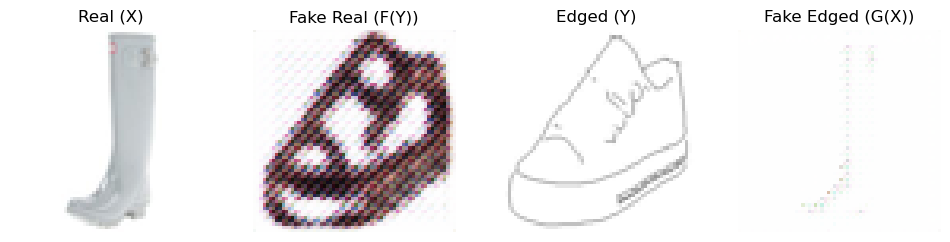

In [5]:
import matplotlib.pyplot as plt

sample_x = X_train[0:1]  
sample_y = Y_train[0:1]  


fake_y = G.predict(sample_x)

fake_x = F.predict(sample_y)

def show_images(imgs, titles):
    plt.figure(figsize=(12,4))
    for i, (img, title) in enumerate(zip(imgs, titles)):
        plt.subplot(1, len(imgs), i+1)
        plt.imshow((img[0]+1)/2)
        plt.title(title)
        plt.axis('off')
    plt.show()

show_images(
    [sample_x, fake_x, sample_y, fake_y],
    ['Real (X)', 'Fake Real (F(Y))', 'Edged (Y)', 'Fake Edged (G(X))']
)